In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from skimage.metrics import structural_similarity as ssim
from scipy.ndimage import median_filter, gaussian_filter
from skimage.restoration import denoise_wavelet, wiener
import math
tf.random.set_seed(3)

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
folder_name = '/content/drive/MyDrive/Scam/Dataset'
files_names = ['benign', 'malignant', 'normal']
img_sz = 300
patch_size = 15  # Adjusted to make (img_sz / patch_size) an integer
projection_dim = 64  # Embedding dimension
transformer_layers = 4  # Number of transformer encoder layers
num_patches = (img_sz // patch_size) ** 2  # Total number of patches
training_data = []

In [ ]:
def create_training_data():
    for file in files_names:
        path = os.path.join(folder_name, file)
        class_num = files_names.index(file)
        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            new_array = cv2.resize(img_array, (img_sz, img_sz))
            training_data.append([new_array, class_num])

create_training_data()

100%|██████████| 266/266 [00:06<00:00, 43.36it/s]


In [ ]:
random.shuffle(training_data)
X = np.array([item[0] for item in training_data]).reshape(-1, img_sz, img_sz, 1) / 255.0
y = np.array([item[1] for item in training_data])

In [ ]:
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
X_train_split, X_val_split = train_test_split(X_train, test_size=0.1, random_state=42)

In [ ]:
class PatchExtractor(layers.Layer):
    def __init__(self, patch_size):
        super(PatchExtractor, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [-1, patches.shape[1] * patches.shape[2], patch_dims])
        return patches

In [ ]:
def transformer_block(inputs):
    x = layers.LayerNormalization()(inputs)
    attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=projection_dim)(x, x)
    x = layers.Add()([attention_output, inputs])

    x = layers.LayerNormalization()(x)
    feed_forward = layers.Dense(projection_dim * 2, activation="relu")(x)
    feed_forward = layers.Dense(projection_dim)(feed_forward)
    return layers.Add()([feed_forward, x])

In [ ]:
class ReconstructImage(layers.Layer):
    def __init__(self, patch_size, img_size):
        super(ReconstructImage, self).__init__()
        self.patch_size = patch_size
        self.img_size = img_size

    def call(self, patches):
        batch_size = tf.shape(patches)[0]
        patches_per_row = self.img_size // self.patch_size
        patches = tf.reshape(patches, (batch_size, patches_per_row, patches_per_row, self.patch_size, self.patch_size, 1))
        patches = tf.transpose(patches, [0, 1, 3, 2, 4, 5])  # Rearrange axes for concatenation
        reconstructed_image = tf.reshape(patches, (batch_size, self.img_size, self.img_size, 1))
        return reconstructed_image

In [ ]:
inputs = layers.Input(shape=(img_sz, img_sz, 1))

In [ ]:
patches = PatchExtractor(patch_size)(inputs)
patch_embeddings = layers.Dense(projection_dim)(patches)

In [ ]:
positions = tf.range(start=0, limit=num_patches, delta=1)
positional_encoding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)(positions)
encoded_patches = patch_embeddings + positional_encoding

In [ ]:
for _ in range(transformer_layers):
    encoded_patches = transformer_block(encoded_patches)

In [ ]:
decoder_outputs = layers.Dense(patch_size * patch_size, activation="sigmoid")(encoded_patches)
decoder_outputs = ReconstructImage(patch_size, img_sz)(decoder_outputs)

In [ ]:
from tensorflow.keras import layers, models

transformer_model = tf.keras.Model(inputs, decoder_outputs)
transformer_model.compile(optimizer="adam", loss="mse")

In [ ]:
history = transformer_model.fit(X_train_split, X_train_split, epochs=128, batch_size=32, validation_data=(X_val_split, X_val_split))

Epoch 1/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 2/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 3/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 4/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 5/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 6/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 7/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 8/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 9/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 10/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 11/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 12/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step

In [ ]:
test_loss = transformer_model.evaluate(X_test, X_test)
print(f"Test Loss: {test_loss}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 5.0932e-04
Test Loss: 0.000492315215524286


In [ ]:
def compute_ssim(original, reconstructed):
    return ssim(original, reconstructed, data_range=reconstructed.max() - reconstructed.min())

def compute_psnr(original, reconstructed):
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        return 100
    max_pixel = 1.0
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse))
    return psnr

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SSIM: 0.7202, PSNR: 78.48 dB


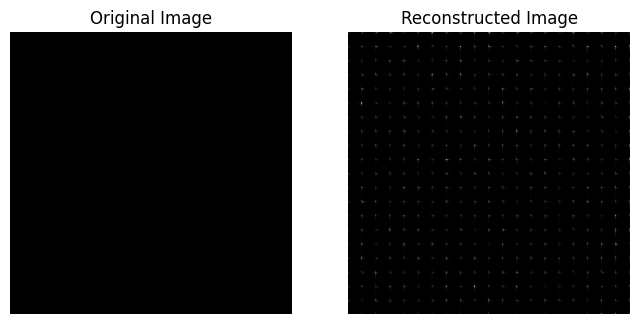

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
SSIM: 0.8720, PSNR: 31.47 dB


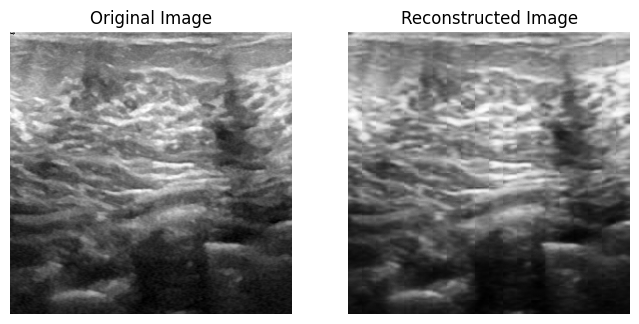

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
SSIM: 0.8727, PSNR: 30.71 dB


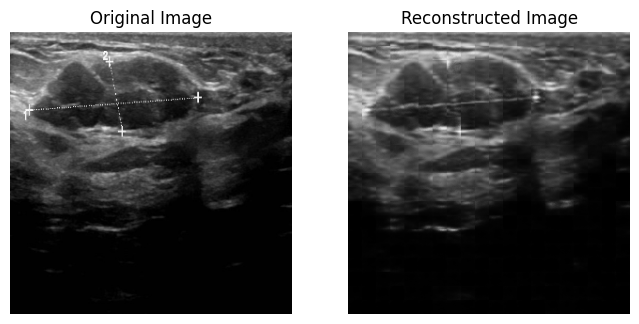

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
SSIM: 0.8539, PSNR: 29.90 dB


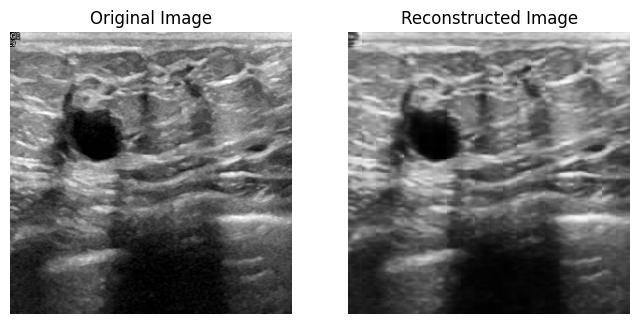

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
SSIM: 0.9935, PSNR: 34.74 dB


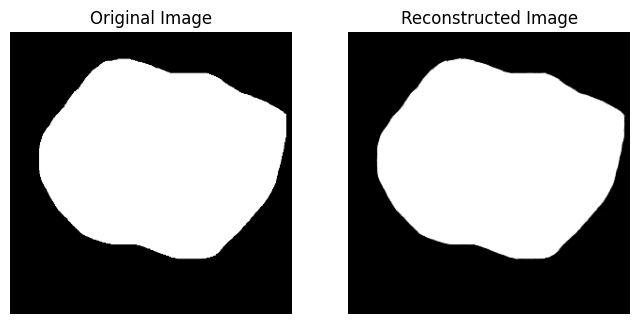

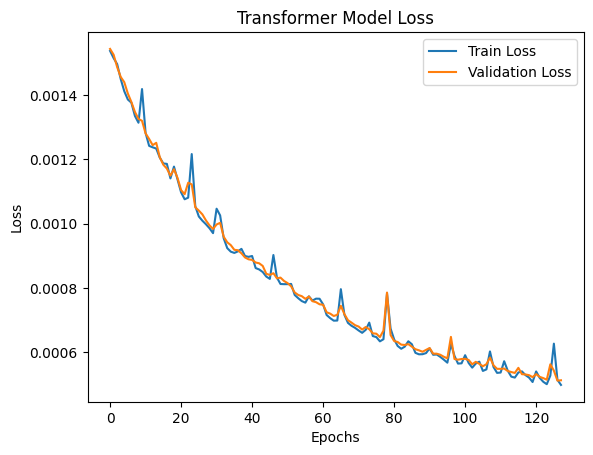

In [ ]:
num_samples = 5
sample_indices = np.random.choice(len(X_test), num_samples, replace=False)

for idx in sample_indices:
    original_image = X_test[idx].reshape(img_sz, img_sz)  # Original image in grayscale
    reconstructed_image = transformer_model.predict(original_image.reshape(1, img_sz, img_sz, 1)).reshape(img_sz, img_sz)

    ssim_value = compute_ssim(original_image, reconstructed_image)
    psnr_value = compute_psnr(original_image, reconstructed_image)
    print(f"SSIM: {ssim_value:.4f}, PSNR: {psnr_value:.2f} dB")

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_image, cmap='gray')
    plt.title("Reconstructed Image")
    plt.axis('off')
    plt.show()

# Plot the loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Transformer Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()